In [1]:
# Загружаем необходимые библиотеки

from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
from IPython.display import Audio
import numpy as np
import pandas as pd

%matplotlib inline

## Load sample 

In [2]:
data = pd.read_csv('/Users/petertantsov/Downloads/ИИС/mnist/mnist_train.csv')

In [3]:
img = data.iloc[0,1:].values

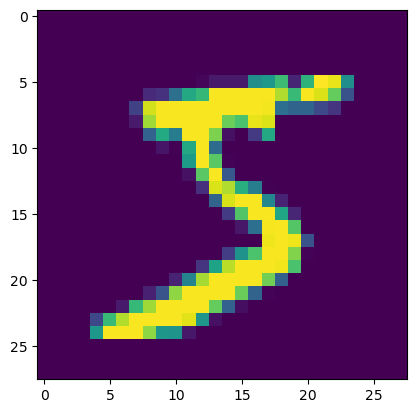

In [4]:
plt.imshow(img.reshape([28,28]))

In [5]:
res = ''

for v in img:
    add = ''
    if v == 255:
        add = '000'
    for i in range(8):
        res += str(v%2)
        v //= 2
    res += add
    
res += '11111111111'

In [6]:
len(res)

6286

In [7]:
res = res + '1111'

In [8]:
len(res)%5

0

## Get frequences for FM

In [11]:
coef_fm = {}

for v in range(32):
    s_r = 1+1/32*v
    bin_i = ''
    for i in range(5):
        bin_i += str(v%2)
        v //= 2
    coef_fm[bin_i] = s_r

In [12]:
coef_fm

{'00000': 1.0,
 '10000': 1.03125,
 '01000': 1.0625,
 '11000': 1.09375,
 '00100': 1.125,
 '10100': 1.15625,
 '01100': 1.1875,
 '11100': 1.21875,
 '00010': 1.25,
 '10010': 1.28125,
 '01010': 1.3125,
 '11010': 1.34375,
 '00110': 1.375,
 '10110': 1.40625,
 '01110': 1.4375,
 '11110': 1.46875,
 '00001': 1.5,
 '10001': 1.53125,
 '01001': 1.5625,
 '11001': 1.59375,
 '00101': 1.625,
 '10101': 1.65625,
 '01101': 1.6875,
 '11101': 1.71875,
 '00011': 1.75,
 '10011': 1.78125,
 '01011': 1.8125,
 '11011': 1.84375,
 '00111': 1.875,
 '10111': 1.90625,
 '01111': 1.9375,
 '11111': 1.96875}

## Signal encoding

In [19]:
sample_rate = 44100

sig = []

t0 = 0

delta = 1/sample_rate

coef = 60

string = res
    
for i in range(0,len(string),5):
    c = string[i:i+5]
    delta = coef_fm[c]/sample_rate

        
    for j in range(sample_rate//coef):
        t0 = t0 + delta
        sig.append(5*np.sin(2*np.pi*440*t0))

In [20]:
# record this audio using mircophone and save as wav format

Audio(data=sig,rate=sample_rate)

## Load audio and decode

In [ ]:
sample_rate, data = wavfile.read('rec19.wav')

In [23]:
sample_rate

22050

In [24]:
data = data[:,0]

In [25]:
data = np.array(data,dtype = np.int64)

In [26]:
Audio(data=data,rate=sample_rate)

In [27]:
move = 0 
start = 0
coef = 60

byte = ''

for i in range(len(data)//(sample_rate//coef)):
    temp = data[sample_rate//coef*i-move:sample_rate//coef*(i+1)-move]
    f = fft(temp,sample_rate)
    res = np.argmax(np.abs(f)[0:2000])

    if start == 1:            
        norm = res/440
        
        min_delta = None
        cur_res = None
        
        for key,value in coef_fm.items():
            if min_delta is None or abs(norm-value) < min_delta:
                min_delta = abs(norm-value)
                cur_res = key
                
        byte += cur_res
            
            
    if res > 400 and res < 440*4+20:
        if start == 0:
            start = 1
            move = len(temp) - np.argmax(temp)

In [28]:
byte

'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

## Decode bytes to picture

In [29]:
j = 0

decoded = []
b = ''
while True:
    if len(b) == 8:
        r = 0
        for i in range(8):
            r += int(b[i])*(2**i)
        if r == 255:
            if byte[j:j+3] != '111':
                decoded.append(255)
                j+=3
                b = ''
            else:
                break
        else:
            decoded.append(r)
            b = ''
    if j == len(byte):
        break
    b = b+byte[j]
    j+=1

In [30]:
len(decoded)

786

In [31]:
out = np.zeros(784)

In [32]:
out[0:min(len(decoded),784)] = decoded[:min(len(decoded),784)]

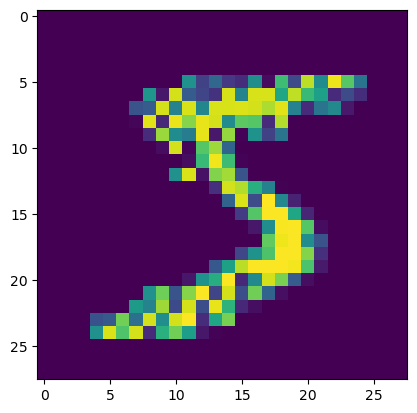

In [33]:
plt.imshow(out.reshape([28,28]))